In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.float_format = '{:,.0f}'.format

# Setup and data collection

The tool was run on a very basic setup:
- the client is a DualSTA compatible laptop, connected over Wi-Fi to an access point
- the server is a connected over ethernet directly to the same access point

The latencies were collected over a 1 hour period, with a bitrate of 5 Mbits per second (equivalent to streaming an hd video), using the command below:
```
> .\MultipathLatencyAnalyzer.exe -target:"10.0.0.192" -prepostrecvs:5 -bitrate:hd -grouping:30 -duration:3600 -output:latencyData.csv
```

# Analysis from the tool output

Once the app is done sending data, we get the following output:

```
-----------------------------------------------------------------------
                            STATISTICS
-----------------------------------------------------------------------

--- OVERVIEW ---

18431992 kb (2303999 datagrams) were sent in 3599 seconds. The effective bitrate was 5121 kB/s.

The secondary interface prevented 2940 lost datagrams
The secondary interface saved 1399099 ms (9%)
266538 datagrams were received first on the secondary interface (11%)

--- DETAILS ---

Sent datagrams on primary interface: 2303999
Sent datagrams on secondary interface: 2296109

Received datagrams on primary interface: 2300051 (99%)
Received datagrams on secondary interface: 2294709 (99%)

Lost datagrams on primary interface: 3948 (0%)
Lost datagrams on secondary interface: 1400 (0%)
Lost datagrams on both interface simultaneously: 1008 (0%)

Average latency on primary interface: 6 ms
Average latency on secondary interface: 9 ms
Average effective latency on combined interface: 5 ms (9% improvement over primary)

Jitter (standard deviation) on primary interface: 9 ms
Jitter (standard deviation) on secondary interface: 6 ms
Jitter (standard deviation) on combined interfaces: 5 ms

Median latency on primary interface: 5 ms
Median latency on secondary interface: 8 ms
Median effective latency on combined interfaces: 5 ms (2% improvement over primary)

Interquartile range on primary interface: 1 ms
Interquartile range on secondary interface: 3 ms
Interquartile range latency on combined interfaces: 1 ms

Minimum / Maximum latency on primary interface: 1 ms / 674 ms
Minimum / Maximum latency on secondary interface: 1 ms / 289 ms

Corrupt datagrams on primary interface: 0
Corrupt datagrams on secondary interface: 0
```

## Lost datagrams
There isn't a lot of lost datagrams (around 1 for each 2000 datagrams), the transmission appear to have been rather reliable.
Even in this context, using a secondary interface reduced the number of lost datagrams by almost 4.
In this session in particular, the secondary interface lost a lot less datagrams than the seondary.

We can however expect a similar reduction even with similar loss rate on both interface:
as long as the reasons the frames are lost are independent between the two Wi-Fi frequency bands, the reduction of the loss rate will be quadratic.

## Average latency
The average latency is worse on the secondary interface than on the primary one (8 ms against 5 ms).
However, 11% of the datagrams were still received on the secondary interface before they were received on the primary interface (even though a datagram is always queued on the primary interface first, giving it a slight edge).
This lead to a 9% reduction of the effective latency (the time between the datagram was first sent and first received, independently of the interface).

There are no penalty for lost datagrams in this average. Datagrams that were saved by the secondary interface are ignored in the primary average latency.
For reliables protocols like TCP, the retransmissions can results in large increase of the latency.

## Jitter
The secondary interface was much more consistent than the primary one here: its standard deviation is of 6 ms against 9 ms.
The maximum latency on the primary interface is also of 674 ms, against 289 ms on the secondary.

This allows for a huge reduction of the effective jitter, which is of 5ms: almost half of the jitter on the primary interface.

# Analysis of the raw output data

Let's now import the output raw data for a closer look.
To keep the size of the file on the repository reasonnable, only the data for first 15 minutes of the run above are present in the file.

In [26]:
latency_data_filename = "latencyData.csv"

timestamps = pd.read_csv(latency_data_filename)
timestamps.replace(-1, np.nan, inplace=True)
timestamps.head()

,Sequence number,Primary Send timestamp (microsec),Primary Echo timestamp (microsec),Primary Receive timestamp (microsec),Secondary Send timestamp (microsec),Secondary Echo timestamp (microsec),Secondary Receive timestamp (microsec)
0,0,63389464336,"68,287,608,120","63,389,860,932",NaN,NaN,NaN
1,1,63389464649,"68,287,611,066","63,389,862,685",NaN,NaN,NaN
2,2,63389464689,"68,287,611,022","63,389,862,654",NaN,NaN,NaN
3,3,63389464735,"68,287,610,959","63,389,862,652",NaN,NaN,NaN
4,4,63389464763,"68,287,610,896","63,389,862,685",NaN,NaN,NaN


The data contains the timestamp when each datagram was sent from the client, echoed by the server and received back by the client.
-1 means the event never occured: the datagram wasn't sent or was lost.

All timestamps are in microseconds. They are relative without a fix origin as they are measured using the `QueryPerformanceCounter` (QPC) API for precise measurements. This means they can only be compared with timestamps collected on the same device: timestamps for sending and receiving data can be compared with each others but not with the timestamps for echoing data, collected on the server.

We also notice that there are no datagram transmitted on the secondary interface for the first sequence numbers: at this time, the secondary interface was still connecting and data was sent over the primary only.

For this analysis, we are more interested by round trip latencies than raw timestamps.

In [27]:

latencies = pd.DataFrame()
latencies['primary'] = timestamps.iloc[:, 3] - timestamps.iloc[:, 1]
latencies['secondary'] = timestamps.iloc[:, 6] - timestamps.iloc[:, 4]


We also need the effective latency for comparison: the time between when the datagram was first sent and the time its echo was first received, independently of this interface.
The effective latency give a measure of the time it took to transfert the information itself and abstract the interfaces.

In [28]:
latenciesNoNan = latencies.fillna(np.inf)
latencies['effective'] = latenciesNoNan.min(axis=1).replace(np.inf, np.nan)
latencies.head()

,primary,secondary,effective
0,"396,596",NaN,"396,596"
1,"398,036",NaN,"398,036"
2,"397,965",NaN,"397,965"
3,"397,917",NaN,"397,917"
4,"397,922",NaN,"397,922"


## Average latency and jitter (again)

First, let's confirm that the output of the app is consistent with the data.
We also print for more percentiles to look for outliers.

In [29]:
latencies.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999])

,primary,secondary,effective
count,"574,511","567,679","575,152"
mean,"6,604","9,524","5,895"
std,"13,120","8,493","10,725"
min,"1,532","1,908","1,532"
10%,"3,912","5,347","3,810"
25%,"4,793","6,731","4,694"
50%,"5,557","8,203","5,425"
75%,"6,492","10,274","6,274"
90%,"7,617","13,519","7,209"
99%,"21,176","31,485","10,900"


As expected, most of the results are close to the ones from the application output.
However, the jitter (standard deviation) is significatively higher than with the full dataset.
In particular, it is now higher on the effective interface than on the secondary interface.
This is rather unexpected: the effective interface tends to be at least as good as the best among the primary and the secondary interface.

The last quantiles also expose outliers: on the primary interface, 1% of the datagrams has a latency above 4 time the average, and 0.1% has a latency over 30 time the average.

To get any graphical representation, we will need to handle these outliers: let's replace them by the maximum value we don't consider as an outlier.

In [30]:
outliersLimit = (latencies.mean() + 3 * latencies.std()).max()
latenciesCeiled = latencies.where(lambda v: v is np.nan or v < outliersLimit, outliersLimit)
latenciesCeiled.describe()

,primary,secondary,effective
count,"576,000","576,000","576,000"
mean,"6,173","9,789","5,692"
std,"4,530","6,579","2,783"
min,"1,532","1,908","1,532"
25%,"4,795","6,758","4,696"
50%,"5,561","8,240","5,427"
75%,"6,501","10,430","6,278"
max,"45,965","45,965","45,965"


This impact pretty drastically the standard deviation.
In particular, the jitter on the effective interface drop to 2 milliseconds. It is likely it was impacted by some of the huge outlier latencies on the primary at the begining of the trace: at this time, the secondary interface wasn't enabled yet to provide a better alternative.

Now that the outliers are out of the picture, the primary interface is both faster and more consistent than the secondary interface.
It also closes the gap with the effective interface: the difference in term or average latencies or jitter is now smaller.

This highlight a first contribution of the secondary interface: it provides an alternative outliers on the primary interface. Capping the value of the outliers reduce the impact of this benefit.

In [31]:
pm, _, em = latenciesCeiled.mean()
print("Effective latency improvement over primary after removing outliers: {:.2f}%".format((pm - em) * 100 / pm))

pstd, _, estd = latenciesCeiled.std()
print("Effective jitter improvement over primary after removing outliers: {:.2f}%".format((pstd - estd) * 100 / pstd))

Effective latency improvement over primary after removing outliers: 7.79%
Effective jitter improvement over primary after removing outliers: 38.56%


## Latencies distribution

We can now have a look to the distributions of the latencies for each interface.

<AxesSubplot:>

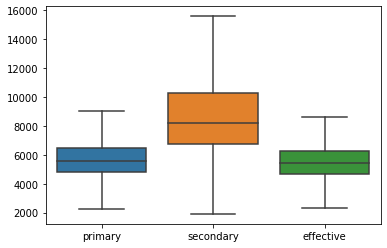

In [32]:
sns.boxplot(data=latencies, showfliers = False)

<AxesSubplot:ylabel='Count'>

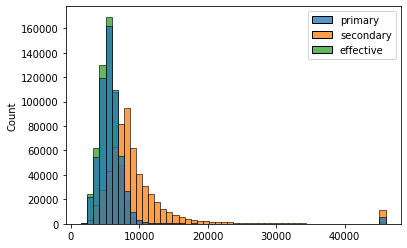

In [33]:
sns.histplot(data=latenciesCeiled, bins=50)

The box plot show that the third quartile of the primary interface is roughtly equal to the first quartile of the secondary interface, but there still is a significant overlap (particularly noticeable on the histogram).

The majority of the datagram had a lower latency on the primary interface (which is expected, as it is using the 5GHz band which has generally less interferences). However, a significant proportion of the latencies in the first quartile of the secondary interface was lower than the corresponding latencies for the primary, which translate on a shift to the left of the effective latencies histogram.

<AxesSubplot:>

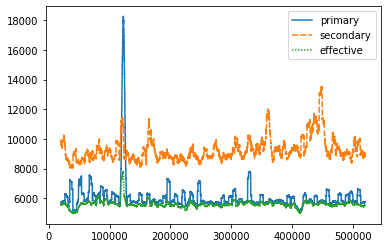

In [34]:
rollingAverageLatencies = latenciesCeiled.rolling(5000).mean()
sns.lineplot(data=rollingAverageLatencies.iloc[20000:520000], ci=None)

A graph of the latencies highlight how the secondary interface compensate for the high latency datagrams on the primary interface.

To get a readable result, we display a sliding average over a fragment of the execution only. Therefore, each spike corresponds to a serie of high latency datagrams potentially mixed up with other lower latency datagrams.

Even if the average latency on the secondary interface is consistenly higher than on the primary interface, the lower latency datagram compensate compensate for the high latency datagrams causing spikes on the primary interface: the effective latency is smoother, as expected from the lowest jitter reported by the tool.

Interestingly, around sequence number 120000, a phenomenon affected both interfaces: they experienced a large spike of latency. However, the consequences on the effective interface are still much more limited. 

# Conclusion

On this particular experiment, using a secondary interface allowed to improve both the average latency and the jitter through two differents vectors:

- Providing an alternative to outliers and lost datagrams on the primary interface
- Leveraging the datagrams that are faster than average on the secondary interface and may end up beating the corresponding datagram on the primary

However, these results are limited to this specific experiment. Depending on the network path between the client and the server, the Wi-Fi landscape or the throughput limitation of the connection (as the secondary interface double the bitrate over the network), the result may differ significatively.